In [ ]:
# Group 14_IANNwTF_Homework 09 - RNN

import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
#from random import randint

##Sequence Generator

In [ ]:
def label(seq, queries):
  """
  This function generates labels for the respective (sequence element, query) pair
  f1 = frequency of the first query
  f2 = frequency of the second query
  
  return: constant 1-D tensor from a list; same frequency case (i.e [1,1]) is ignored
  """
  f1 = tf.reduce_sum(tf.cast(tf.equal(seq, queries[0]), tf.int32)) 
  f2 = tf.reduce_sum(tf.cast(tf.equal(seq, queries[1]), tf.int32)) 
    
  return tf.constant([int(f1>f2), int(f2>f1)])

In [ ]:
# sequence generator (an interable)
seq_len = 25

def seq_gen():
  while True:
    seq = np.random.randint(10, size=seq_len)
    # alternative: create a list with int 0-9 and sample two from it
    queries = np.random.randint(10, size=2)
    target = label(seq, queries)
    yield seq, queries, target

##Create the dataset

In [ ]:
dataset_raw = tf.data.Dataset.from_generator(seq_gen,
                                         output_types=(tf.int32, tf.int32, tf.float32))

##Inspect the dataset

In [ ]:
for sample in dataset_raw.take(1):
  print('sequence is: ', sample[0])
  print('queries are: ', sample[1])
  print('label is: ', sample[2])

sequence is:  tf.Tensor([5 4 4 9 3 1 7 3 0 7 6 6 0 4 0 6 8 7 6 9 6 0 3 5 5], shape=(25,), dtype=int32)
queries are:  tf.Tensor([5 9], shape=(2,), dtype=int32)
label is:  tf.Tensor([1. 0.], shape=(2,), dtype=float32)


##Preprocessing

###Helper Functions

In [ ]:
# tf.repeat solves the concat shape error we encountered previously
def input_gen(seq, queries):
  seq = tf.one_hot(seq, 10)
  queries = tf.one_hot(queries, 10)
  queries = tf.reshape(queries, (1,20))
  queries = tf.repeat(queries, seq_len, axis=0)
  out = tf.concat((seq, queries), axis=-1)
  return out

In [ ]:
tf.repeat(['a', 'b', 'c'], repeats=[3, 0, 2], axis=0) # what's this b for?

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'a', b'a', b'a', b'c', b'c'], dtype=object)>

In [ ]:
dataset_preprocessed = dataset_raw.map(lambda seq, queries, label: (input_gen(seq, queries), label)) 

In [ ]:
for sample in dataset_preprocessed.take(1):
  print('sequence is: ', sample[0])
  print('label is: ', sample[1])

sequence is:  tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.

In [ ]:
batch_size = 64

# create train and test datasets
train_dataset = dataset_preprocessed.take(6400).cache()
test_dataset = dataset_preprocessed.take(640).cache()

# batch & prefetch
train_dataset_batched = train_dataset.batch(batch_size)
train_dataset = train_dataset_batched.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset_batched = test_dataset.batch(batch_size)
test_dataset = test_dataset_batched.prefetch(tf.data.experimental.AUTOTUNE)

#Preprocessing Steps (Includes batching)

In [ ]:
batch_size = 64
TRAIN_DATASET_COUNT = 6400
TEST_DATASET_COUNT = 640
TOTAL_DATASET_COUNT = TRAIN_DATASET_COUNT + TEST_DATASET_COUNT

dataset_entries = TOTAL_DATASET_COUNT #Change this to increase number of dataset entries
tensor_list = []
label_list = []
for seq, que, lab in dataset_raw:
    single_input = input_gen_new(seq, que)
    tensor_list.append(single_input)
    label_list.append(lab)
    dataset_entries -= 1
    if dataset_entries == 0:
        break

input_dataset = None
first_input = True
for each in tensor_list:
    if first_input == True:
        input_dataset = tf.data.Dataset.from_tensors(each)
        first_input = False;
    else:
        input_dataset = input_dataset.concatenate(tf.data.Dataset.from_tensors(each))

label_dataset = None
first_label = True
for each in label_list:
    if first_label == True:
        label_dataset = tf.data.Dataset.from_tensors(each)
        first_label = False;
    else:
        label_dataset = label_dataset.concatenate(tf.data.Dataset.from_tensors(each))


dataset_preprocessed = tf.data.Dataset.zip((input_dataset, label_dataset))

# for dataset_tuple in dataset_preprocessed: #This is the same as the one below
#     print("INPUT:", dataset_tuple[0])
#     print("LABEL:", dataset_tuple[1])

# for input, label in dataset_preprocessed:
#     print("INPUT:", input)
#     print("LABEL:", label)

# create train and test datasets
train_dataset = dataset_preprocessed.take(TRAIN_DATASET_COUNT).cache()
test_dataset = dataset_preprocessed.take(TEST_DATASET_COUNT).cache()

# batch & prefetch
train_dataset_batched = train_dataset.batch(batch_size)
train_dataset = train_dataset_batched.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset_batched = test_dataset.batch(batch_size)
test_dataset = test_dataset_batched.prefetch(tf.data.experimental.AUTOTUNE)

##LSTM Implementation

###LSTM_Cell

In [ ]:
class LstmCell(Model):
  """
  x: input at a single timestep 
  hidden state, cell state: need to be given
  To increase the deepness of the network, one could use MLP with 3 layers (e.g.) to replace the Dense layer
  """
  def __init__(self, unit_num):
    # num_units: int, The number of hidden units in the LSTM cell. 
    # --> the dimensionality of hidden state and cell state
    super(LstmCell, self).__init__()

    self.forget_gate = tf.keras.layers.Dense(
        units=unit_num,
        activation='sigmoid',
        bias_initializer='ones',
        name = 'forget_gate'
    )

    self.input_gate = tf.keras.layers.Dense(
        units=unit_num,
        activation='sigmoid',
        name = 'input_gate'
    )

    self.candidate = tf.keras.layers.Dense(
        units=unit_num,
        activation='tanh',
        name = 'candidate'
    )
    self.output_gate = tf.keras.layers.Dense(
        units=unit_num,
        activation='sigmoid',
        bias_initializer='ones',
        name = 'output_gate'
    )
    
  #@tf.function
  def call(self, x, h_c):
    hidden_state, cell_state = h_c
    # if hidden_state and x have only 1 dim, below '1' is not needed
    concat_input = tf.concat((hidden_state, x), 1)
    f_t = self.forget_gate(concat_input)
    i_t = self.input_gate(concat_input)
    c_tilde_t = self.candidate(concat_input)
    o_t = self.output_gate(concat_input)

    # updating cell_state and new hidden_state will be handled in LSTM, outside LstmCell

    return f_t, i_t, c_tilde_t, o_t



###Inspect LstmCell

In [ ]:
batch_size = 64
cell = LstmCell(10)
f_t, i_t, c_tilde_t, o_t = cell(tf.ones((batch_size, 30)),
         (tf.zeros((batch_size, 10)), tf.zeros((batch_size, 10)))
         )
cell.summary()
print('f_t is: ', f_t)

Model: "lstm_cell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
forget_gate (Dense)          multiple                  410       
_________________________________________________________________
input_gate (Dense)           multiple                  410       
_________________________________________________________________
candidate (Dense)            multiple                  410       
_________________________________________________________________
output_gate (Dense)          multiple                  410       
Total params: 1,640
Trainable params: 1,640
Non-trainable params: 0
_________________________________________________________________
f_t is:  tf.Tensor(
[[0.6077528  0.6393125  0.5168362  0.42871913 0.76921064 0.63003635
  0.94151366 0.54948413 0.45439377 0.38484314]
 [0.6077528  0.6393125  0.5168362  0.42871913 0.76921064 0.63003635
  0.94151366 0.54948413 0.45439377 0.38484314]
 [0

### LSTM

In [ ]:
class LSTM(Model):
  """ 
  consists of readin layer (i.e. MLP), LSTM (made up of one LSTM cell/more), 
  readout layer (i.e. Dense layer) that takes the output of LSTM and output of size 1
  
  Define the readin layer & output layer separately from the LSTM cell(s) 
  --> read-in layer (linear layer) reads the one-hot encoded and turn the sparse representation (input of length 30 contains mostly 0s)
  into an embedding (dense representation of the three inputs) --> more useful for the model
  
  In graph mode, return output & tuple (hidden_state, cell_state) to manage them outside LSTM cell and in LSTM (i.e. avoid creating new variables); 
  otherwise, error occurs

  Graph mode prefers to have arrays with predefined shape to later write outputs, instead of empty array --> why TensorArray is created and used

  """
  def __init__(self, unit_num = 10):
    super(LSTM, self).__init__()
    # Dense layer need a batch size to work --> must be defined explicitly
    self.unit_num = unit_num
    # # of output units for Dense layer should equal to # of hidden units/unit_num?? 
    self.input_layer = tf.keras.layers.Dense(units=10, activation='relu')
    self.lstm_cell = LstmCell(unit_num)
    self.flatten_layer = tf.keras.layers.Flatten()
    # or 2 output neurons with softmax --> if the label is (0,1)/(1,0), use softmax?
    self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid') 

  #@tf.function
  def call(self, x):
    # number of timesteps = seq_len
    # t = tf.constant(0))
    outputs = tf.TensorArray(tf.float32, size = seq_len)

    # cell_state & hidden_state are vectors of the same size (batch_size, units)
    # zero state for both cell state & hidden state
    cell_state = tf.zeros(shape = (batch_size, self.unit_num), dtype = tf.float32)
    hidden_state = tf.zeros(shape = (batch_size, self.unit_num), dtype = tf.float32)

    x = self.input_layer(x)
    for i in tf.range(seq_len):
      # x[:,i] --> take the i-th col as input at i-th timestep
      f_t, i_t, c_tilde_t, o_t = self.lstm_cell(x[:,i,:], (hidden_state, cell_state))
      cell_state = tf.math.multiply(cell_state, f_t) + tf.math.multiply(i_t, c_tilde_t)
      hidden_state = tf.math.multiply(tf.math.tanh(cell_state), o_t)
      output = self.output_layer(self.flatten_layer(hidden_state))
      outputs = outputs.write(i, output)
      # print(tf.shape(outputs))

    # .stack() is used to get normal tensor out of the TensorArray 
    # transpose & perm? seq, batch, unit
    outputs = tf.transpose(outputs.stack(), perm=[1,0,2])
    #print('outputs are ', outputs)
    return outputs

###Inspect LSTM

In [ ]:
batch_size = 64
seq_len = 25
lstm = LSTM()
outputs = lstm(tf.ones((batch_size, seq_len, 30)))
lstm.summary()
#outputs

Model: "lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  310       
_________________________________________________________________
lstm_cell_1 (LstmCell)       multiple                  840       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  11        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


##Training steps

In [ ]:
# suppose to create new dataset at each epoch??

def train_step(model, input, target, loss_function, optimizer):
  target = tf.expand_dims(target, axis=-1)
  with tf.GradientTape() as tape:
    prediction = model(input)
    # what is prediction[:,-1,:]? -1?
    loss = loss_function(target, prediction[:,-1,:]) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  test_losses = []
  test_accuracies = []
    
  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction[:,-1,:]) + tf.reduce_sum(model.losses)
    
    # print('line 20: sample_test_loss is ', sample_test_loss)
    # axis=0 is the batch_size, axis=1 is the one-hot encoding of the labels
        
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction[:,-1,:], axis=1)
    
    test_losses.append(sample_test_loss.numpy())
    # compute the sample_test_accuracy for each batch before appending
    test_accuracies.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)

  return test_loss, test_accuracy    

In [ ]:
# visualize accuracy and loss for train_ds & test_ds
def plot(train_losses, test_losses, test_accuracies, figsize=(10,3)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
  axes[0].plot(train_losses, label='train')
  axes[0].plot(test_losses, label='test')
  axes[0].set_xlabel('Epoches')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss', fontsize=20)
  axes[0].legend()
  axes[1].plot(test_accuracies)
  axes[1].set_xlabel('Epoches')
  axes[1].set_ylabel('Accuracy')
  plt.ylim(0,1.0)
  axes[1].set_title('Accuracy' + str(round(np.max(test_accuracies))), fontsize=20)
  plt.show()

##Training

testing once on test data before start
check how model performs on train data once before start
Starting training
Epoch:  0
running average is  0.6476571
Train loss in Epoch  0  is  0.6476571
Test loss in Epoch  0  is  0.6556913
Test accuracy in Epoch  0  is  0.6390625


Epoch:  1
running average is  0.6345079
Train loss in Epoch  1  is  0.6345079
Test loss in Epoch  1  is  0.6486094
Test accuracy in Epoch  1  is  0.6390625


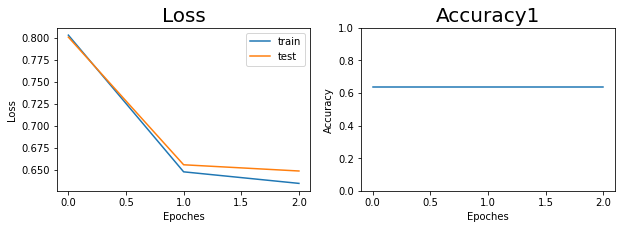

Epoch:  2
running average is  0.6209181
Train loss in Epoch  2  is  0.6209181
Test loss in Epoch  2  is  0.6381208
Test accuracy in Epoch  2  is  0.6390625


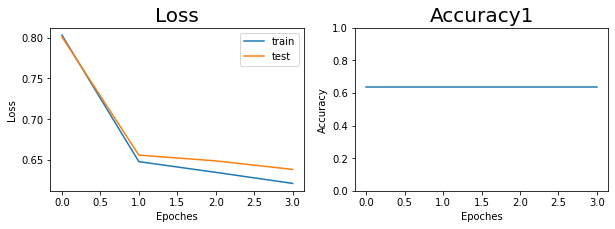

Epoch:  3
running average is  0.6110965
Train loss in Epoch  3  is  0.6110965
Test loss in Epoch  3  is  0.63055104
Test accuracy in Epoch  3  is  0.6390625


Epoch:  4
running average is  0.6051843
Train loss in Epoch  4  is  0.6051843
Test loss in Epoch  4  is  0.62708473
Test accuracy in Epoch  4  is  0.6390625


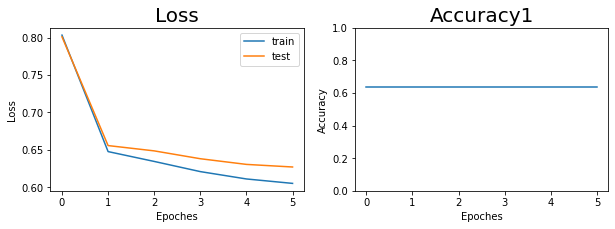

Epoch:  5
running average is  0.60275346
Train loss in Epoch  5  is  0.60275346
Test loss in Epoch  5  is  0.6262035
Test accuracy in Epoch  5  is  0.6390625


Epoch:  6
running average is  0.6013729
Train loss in Epoch  6  is  0.6013729
Test loss in Epoch  6  is  0.6254405
Test accuracy in Epoch  6  is  0.6390625


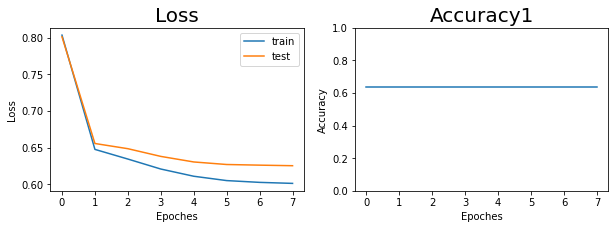

Epoch:  7
running average is  0.60030335
Train loss in Epoch  7  is  0.60030335
Test loss in Epoch  7  is  0.62500006
Test accuracy in Epoch  7  is  0.6390625


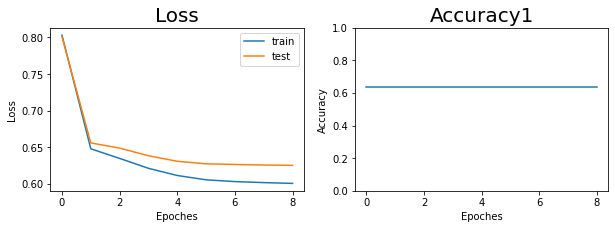

Epoch:  8
running average is  0.5995443
Train loss in Epoch  8  is  0.5995443
Test loss in Epoch  8  is  0.6245512
Test accuracy in Epoch  8  is  0.6390625


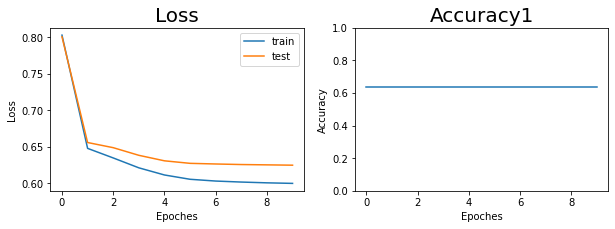

Epoch:  9
running average is  0.59909195
Train loss in Epoch  9  is  0.59909195
Test loss in Epoch  9  is  0.62490255
Test accuracy in Epoch  9  is  0.6390625


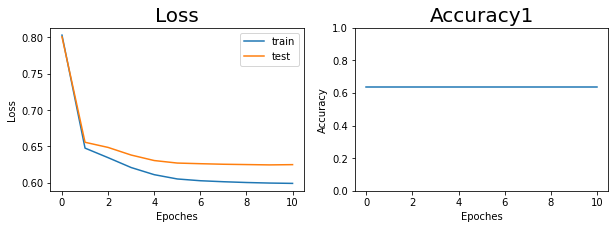

Epoch:  10
running average is  0.5984053
Train loss in Epoch  10  is  0.5984053
Test loss in Epoch  10  is  0.6258589
Test accuracy in Epoch  10  is  0.6390625


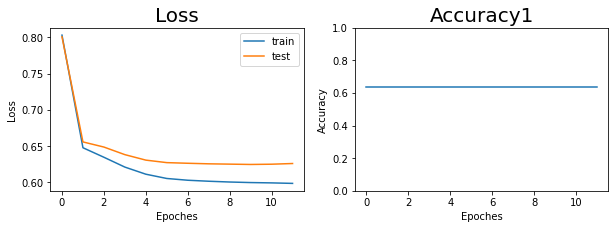

Epoch:  11
running average is  0.59781826
Train loss in Epoch  11  is  0.59781826
Test loss in Epoch  11  is  0.624125
Test accuracy in Epoch  11  is  0.6390625


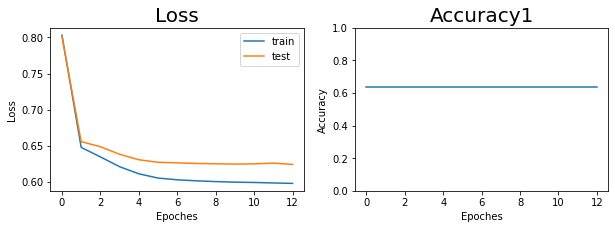

Epoch:  12
running average is  0.59737295
Train loss in Epoch  12  is  0.59737295
Test loss in Epoch  12  is  0.62460744
Test accuracy in Epoch  12  is  0.6390625


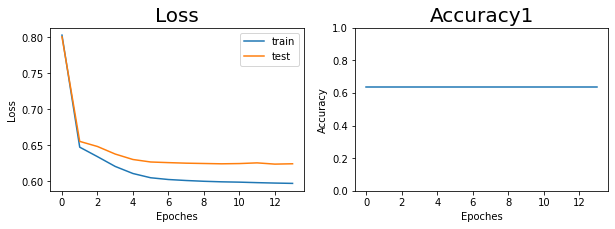

Epoch:  13
running average is  0.5969819
Train loss in Epoch  13  is  0.5969819
Test loss in Epoch  13  is  0.6248336
Test accuracy in Epoch  13  is  0.6390625


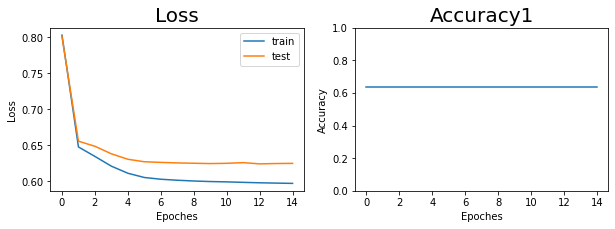

Epoch:  14
running average is  0.5967008
Train loss in Epoch  14  is  0.5967008
Test loss in Epoch  14  is  0.63163304
Test accuracy in Epoch  14  is  0.6390625


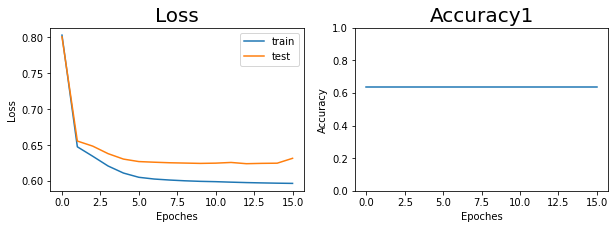

Epoch:  15
running average is  0.59698737
Train loss in Epoch  15  is  0.59698737
Test loss in Epoch  15  is  0.6243632
Test accuracy in Epoch  15  is  0.6390625


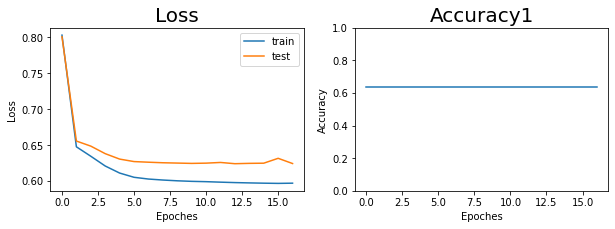

Epoch:  16
running average is  0.59652185
Train loss in Epoch  16  is  0.59652185
Test loss in Epoch  16  is  0.6239673
Test accuracy in Epoch  16  is  0.6390625


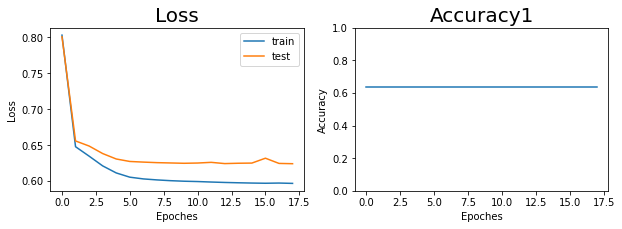

Epoch:  17
running average is  0.59606206
Train loss in Epoch  17  is  0.59606206
Test loss in Epoch  17  is  0.6244611
Test accuracy in Epoch  17  is  0.6390625


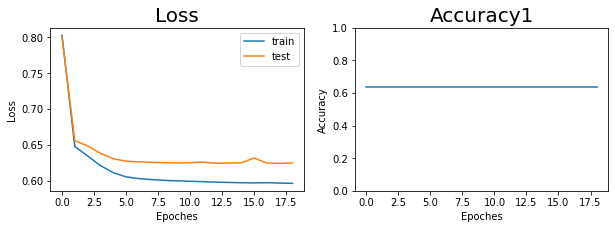

Epoch:  18
running average is  0.5961391
Train loss in Epoch  18  is  0.5961391
Test loss in Epoch  18  is  0.62505597
Test accuracy in Epoch  18  is  0.6390625


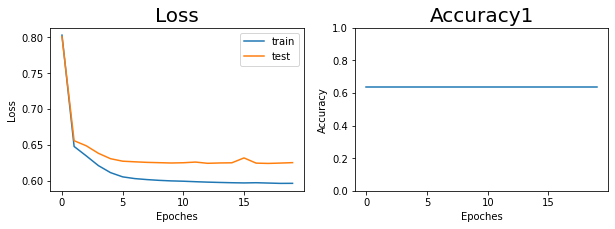

Epoch:  19
running average is  0.59553355
Train loss in Epoch  19  is  0.59553355
Test loss in Epoch  19  is  0.6250777
Test accuracy in Epoch  19  is  0.6390625


Epoch:  20
running average is  0.595187
Train loss in Epoch  20  is  0.595187
Test loss in Epoch  20  is  0.6252977
Test accuracy in Epoch  20  is  0.6390625


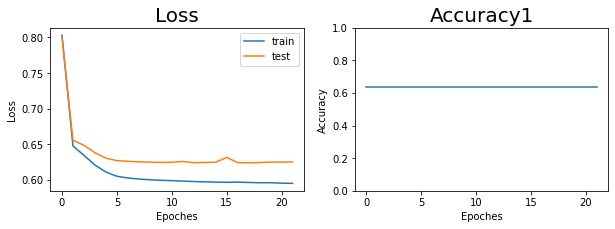

Epoch:  21
running average is  0.59491485
Train loss in Epoch  21  is  0.59491485
Test loss in Epoch  21  is  0.6248306
Test accuracy in Epoch  21  is  0.6390625


Epoch:  22
running average is  0.59454024
Train loss in Epoch  22  is  0.59454024
Test loss in Epoch  22  is  0.62580585
Test accuracy in Epoch  22  is  0.6390625


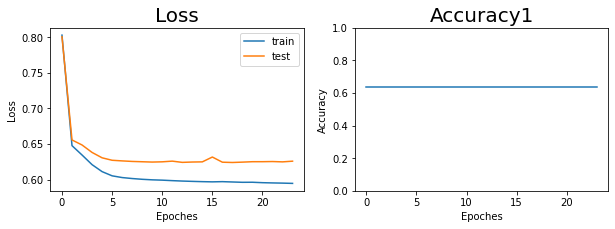

Epoch:  23
running average is  0.59426296
Train loss in Epoch  23  is  0.59426296
Test loss in Epoch  23  is  0.6257821
Test accuracy in Epoch  23  is  0.6390625


Epoch:  24
running average is  0.59411955
Train loss in Epoch  24  is  0.59411955
Test loss in Epoch  24  is  0.62669784
Test accuracy in Epoch  24  is  0.6390625


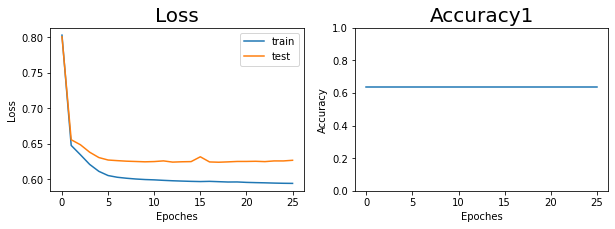

Epoch:  25
running average is  0.59392715
Train loss in Epoch  25  is  0.59392715
Test loss in Epoch  25  is  0.6255368
Test accuracy in Epoch  25  is  0.6390625


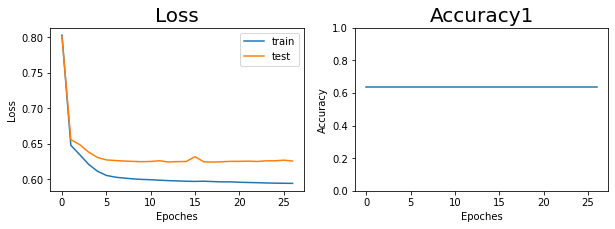

Epoch:  26
running average is  0.5935208
Train loss in Epoch  26  is  0.5935208
Test loss in Epoch  26  is  0.62573326
Test accuracy in Epoch  26  is  0.6390625


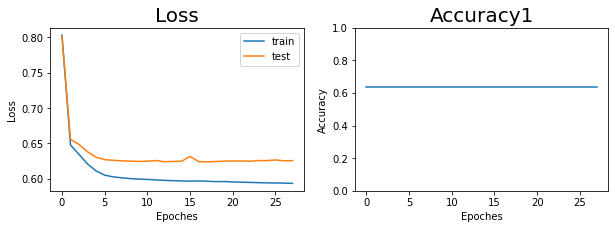

Epoch:  27
running average is  0.59313005
Train loss in Epoch  27  is  0.59313005
Test loss in Epoch  27  is  0.62678325
Test accuracy in Epoch  27  is  0.6390625


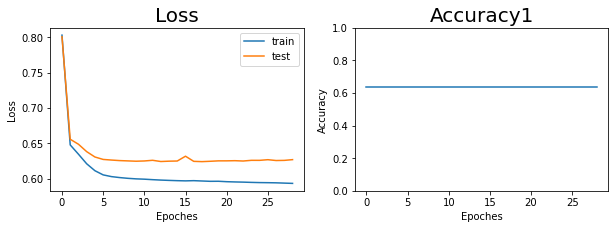

Epoch:  28
running average is  0.5935031
Train loss in Epoch  28  is  0.5935031
Test loss in Epoch  28  is  0.6273605
Test accuracy in Epoch  28  is  0.6390625


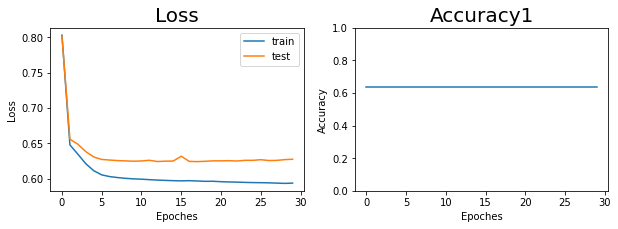

Epoch:  29
running average is  0.5930277
Train loss in Epoch  29  is  0.5930277
Test loss in Epoch  29  is  0.62618995
Test accuracy in Epoch  29  is  0.6390625


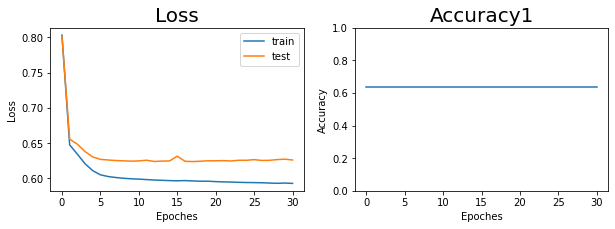

Epoch:  30
running average is  0.592578
Train loss in Epoch  30  is  0.592578
Test loss in Epoch  30  is  0.6264812
Test accuracy in Epoch  30  is  0.6390625


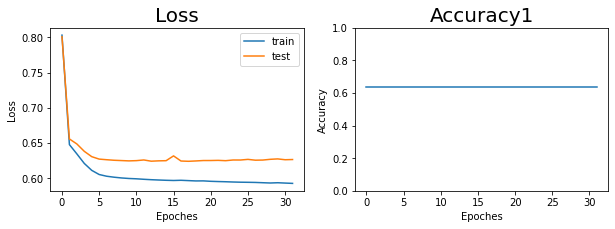

Epoch:  31
running average is  0.5925919
Train loss in Epoch  31  is  0.5925919
Test loss in Epoch  31  is  0.6266928
Test accuracy in Epoch  31  is  0.6390625


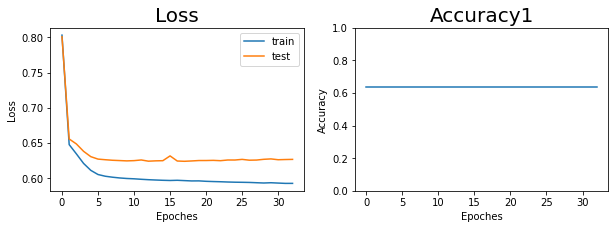

Epoch:  32
running average is  0.5930437
Train loss in Epoch  32  is  0.5930437
Test loss in Epoch  32  is  0.6266986
Test accuracy in Epoch  32  is  0.6390625


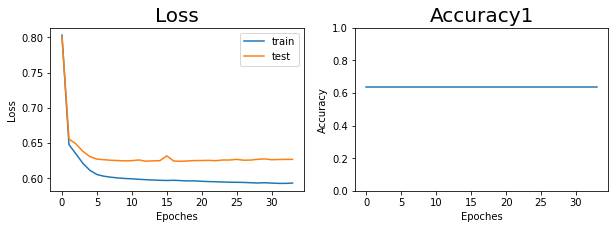

Epoch:  33
running average is  0.59234434
Train loss in Epoch  33  is  0.59234434
Test loss in Epoch  33  is  0.6262833
Test accuracy in Epoch  33  is  0.6390625


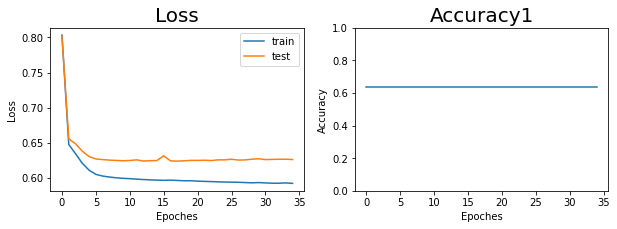

Epoch:  34
running average is  0.5918714
Train loss in Epoch  34  is  0.5918714
Test loss in Epoch  34  is  0.627087
Test accuracy in Epoch  34  is  0.6390625


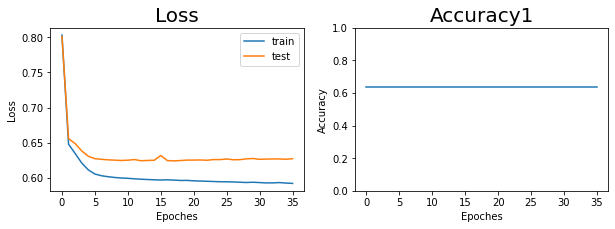

Epoch:  35
running average is  0.5934038
Train loss in Epoch  35  is  0.5934038
Test loss in Epoch  35  is  0.6273635
Test accuracy in Epoch  35  is  0.6390625


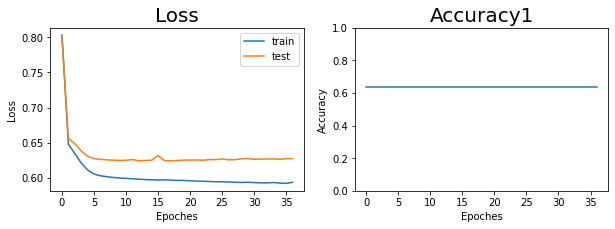

Epoch:  36
running average is  0.59219635
Train loss in Epoch  36  is  0.59219635
Test loss in Epoch  36  is  0.62678224
Test accuracy in Epoch  36  is  0.6390625


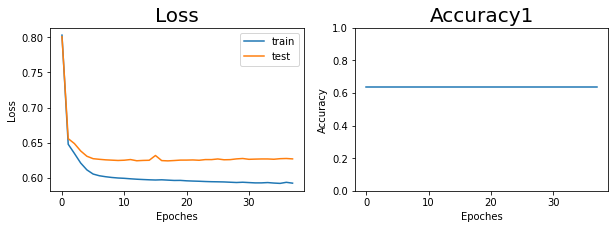

Epoch:  37
running average is  0.59109056
Train loss in Epoch  37  is  0.59109056
Test loss in Epoch  37  is  0.6276643
Test accuracy in Epoch  37  is  0.6390625


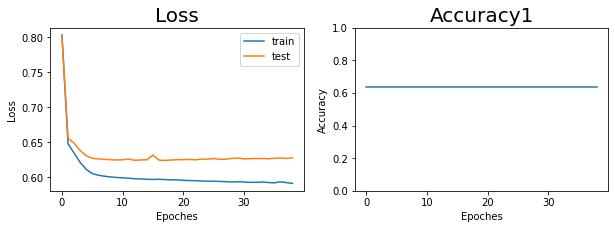

Epoch:  38


KeyboardInterrupt: ignored

In [ ]:
# Loss function could be either BCE
# (ignore the equal instance, which needs enough equal samples to train but in randomly generated case, it is hardly possible)
# or regression (-1: one is more common, 0: both is more common, 1: the other one is more common --> linear)

# at each time step, depth of 30 as input; input shape is (batch_size, # of timesteps, 30)

tf.keras.backend.clear_session()

num_epochs = 40
learning_rate = 0.001
running_average_factor = 0.95
unit_num = 20

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# Define the loss
loss_function = tf.keras.losses.BinaryCrossentropy()

# Initialize the model
model = LSTM(unit_num)

# Initialize lists for later visualization
train_losses = []

test_losses = []
test_accuracies =[]

print("testing once on test data before start")
test_loss, test_accuracy = test(model, test_dataset, loss_function)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print("check how model performs on train data once before start")
train_loss, _ = test(model, train_dataset, loss_function)
train_losses.append(train_loss)

# Train for num_epochs
print("Starting training")
for epoch in range(num_epochs):
  print('Epoch: ', str(epoch))

  # training
  running_average = 0
  for (sample, target) in train_dataset:
    train_loss = train_step(model, sample, target, loss_function, optimizer)
    running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
  print('running average is ', tf.get_static_value(running_average))
  train_losses.append(tf.get_static_value(running_average))
  print('Train loss in Epoch ', epoch, ' is ', tf.get_static_value(running_average))

  # testing
  test_loss, test_accuracy = test(model, test_dataset, loss_function)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print('Test loss in Epoch ', epoch, ' is ', test_loss)
  print('Test accuracy in Epoch ', epoch, ' is ', test_accuracy)
  plot(train_losses, test_losses, test_accuracies)